# Classifying Bristol Neighbourhoods from Airbnb data

Being able to identify a neighbourhood from Airbnb data could help gain insight on what features contribute towards distinguish one neighbourhood over another. Such an analysis could be carried out in a larger study in order to identify up-and-coming, or gentrified, neighbourhoods.

In [1]:
import pandas as pd
import seaborn as sns
sns.set();
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("BristolAirbnbListings.csv")
len(df)

2375

In [3]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood                      object
postcode                           object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                       object
bathrooms                          object
bedrooms                           object
beds                               object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
review_scores_rating               object
review_scores_accuracy             object
review_scores_cleanliness          object
review_scores_checkin              object
review_scores_communication       

In [4]:
df = df[["neighbourhood", "property_type", "room_type", "accommodates", "latitude", "longitude",
          "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "number_of_reviews",
         "reviews_per_month", "calculated_host_listings_count", "availability_365"]]

In [5]:
set(df.room_type)

{'Entire home/apt', 'Private room', 'Shared room'}

In [6]:
set(df.neighbourhood)

{'Ashley',
 'Avonmouth & Lawrence Weston',
 'Bedminster',
 'Bishopston & Ashley Down',
 'Bishopsworth',
 'Brislington East',
 'Brislington West',
 'Central',
 'Clifton',
 'Clifton Down',
 'Cotham',
 'Easton',
 'Eastville',
 'Filwood',
 'Frome Vale',
 'Hartcliffe & Withywood',
 'Henbury & Brentry',
 'Hengrove & Whitchurch Park',
 'Hillfields',
 'Horfield',
 'Hotwells & Harbourside',
 'Knowle',
 'Lawrence Hill',
 'Lockleaze',
 'Redland',
 'Southmead',
 'Southville',
 'St George Central',
 'St George Troopers Hill',
 'St George West',
 'Stockwood',
 'Stoke Bishop',
 'Westbury-on-Trym & Henleaze',
 'Windmill Hill'}

In [7]:
df.loc[(df["room_type"] == "Private room") | (df["room_type"] == "Shared room"), 'room_type'] = "no"
df.loc[df["room_type"] == "Entire home/apt", "room_type"] = "yes"
df = df.rename(index=str, columns={"room_type": "entire_home"})

## Univariate Analysis

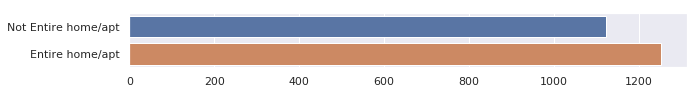

In [8]:
plt.figure(figsize=(10,1))
from collections import Counter
cnt = Counter(df.entire_home.sort_values())
ax = sns.barplot(x=list(cnt.values()), y=["Not Entire home/apt", "Entire home/apt"])

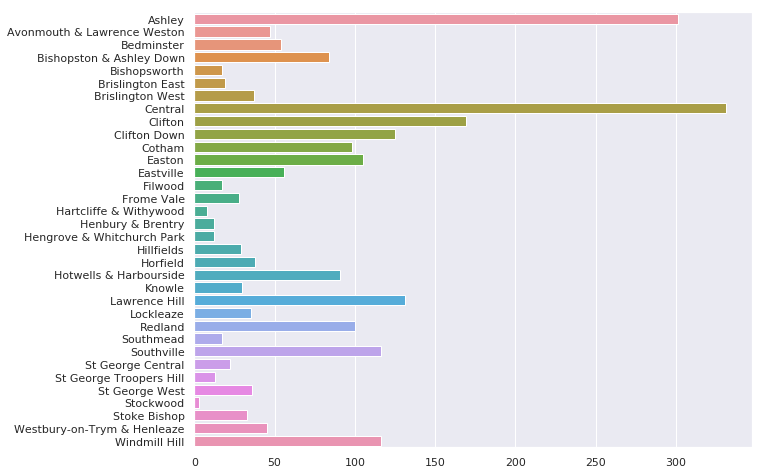

In [9]:
plt.figure(figsize=(10,8))
cnt = Counter(df.neighbourhood.sort_values())
ax = sns.barplot(x=list(cnt.values()), y=list(cnt.keys()))

1758


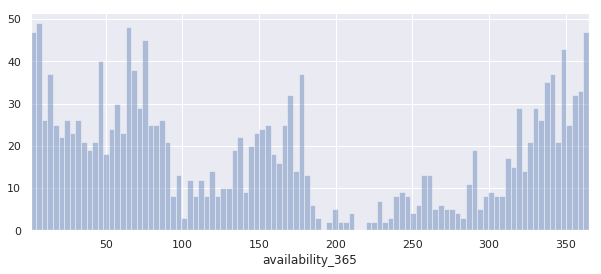

In [10]:
print(len(df.loc[df.availability_365 != 0, 'availability_365']))
plt.figure(figsize=(10,4))
sns.distplot(df.loc[df.availability_365 != 0, 'availability_365'], 100, kde=False)
lims = plt.xlim(1, max(df.availability_365))

## Multivariate Analysis

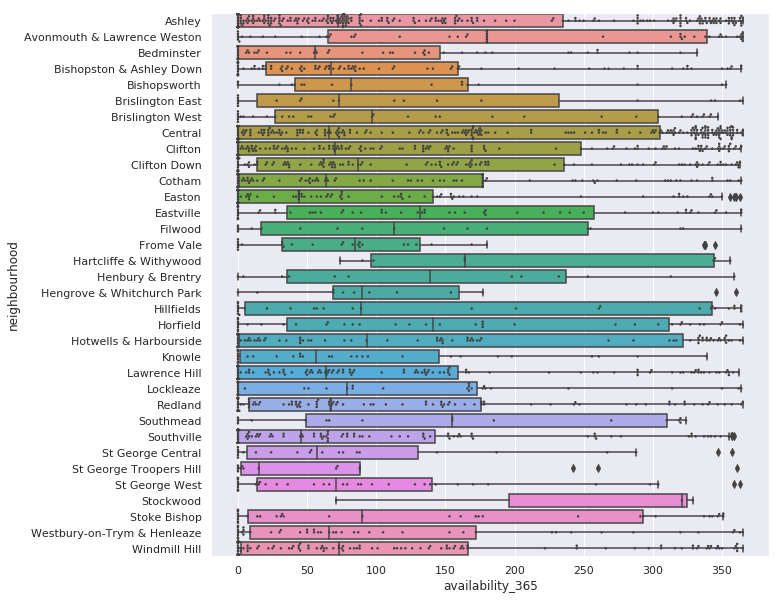

In [11]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(x=df.availability_365, y=df.neighbourhood.sort_values(), orient='h')
ax = sns.swarmplot(x=df.availability_365, y=df.neighbourhood.sort_values(), size=2.5, color=".25")

In [12]:
dummies = pd.get_dummies(df.entire_home, prefix="entire_home")
df = df.drop(columns="entire_home")
df = pd.concat([df, dummies], axis=1)

In [13]:
df.accommodates = pd.to_numeric(df.accommodates, errors='coerce', downcast='signed')
print(len(df[df.accommodates.isnull()]))
df = df.dropna(subset=['accommodates'])

22


In [14]:
df.bathrooms = pd.to_numeric(df.bathrooms, errors='coerce')
print(len(df[df.bathrooms.isnull()]))
df = df.dropna(subset=['bathrooms'])

3


In [15]:
df.bedrooms = pd.to_numeric(df.bedrooms, errors='coerce', downcast='signed')
print(len(df[df.bedrooms.isnull()]))
df = df.dropna(subset=['bedrooms'])

3


In [16]:
df.beds = pd.to_numeric(df.beds, errors='coerce', downcast='signed')
print(len(df[df.beds.isnull()]))
df = df.dropna(subset=['beds'])

2


In [17]:
df.isnull().any()

neighbourhood                     False
property_type                     False
accommodates                      False
latitude                          False
longitude                         False
bathrooms                         False
bedrooms                          False
beds                              False
price                             False
minimum_nights                    False
number_of_reviews                 False
reviews_per_month                  True
calculated_host_listings_count    False
availability_365                  False
entire_home_no                    False
entire_home_yes                   False
dtype: bool

In [18]:
print(len(df[df.reviews_per_month.isnull()]))
print(len(df.loc[(df.reviews_per_month.isnull()) & (df.number_of_reviews == 0), 'reviews_per_month']))
df.loc[(df.reviews_per_month.isnull()) & (df.number_of_reviews == 0), 'reviews_per_month'] = 0
df[df.reviews_per_month.isnull()]
df = df.dropna(subset=['reviews_per_month'])

304
301


In [19]:
df_no_geo = df.drop(columns=["latitude", "longitude"])
df_short = df_no_geo.drop(columns=["entire_home_no", "entire_home_yes", "neighbourhood", "property_type"])
df_short_no_av = df_short.drop(columns=["availability_365"])

In [20]:
def plotHistBox(col):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,4))
    sns.boxplot(df[col], ax=ax_box)
    sns.distplot(df[col], bins=150, ax=ax_hist, kde=False)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

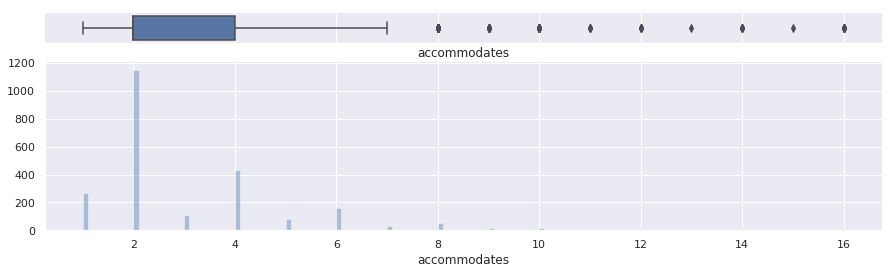

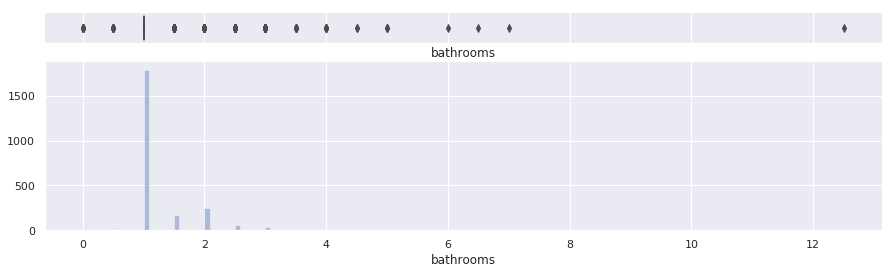

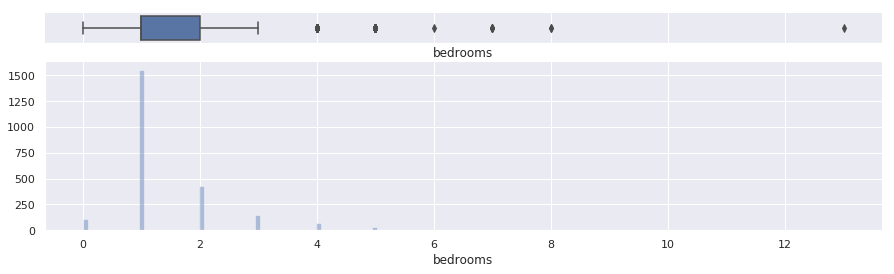

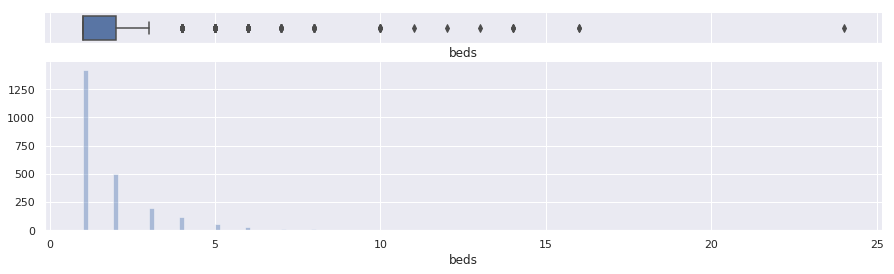

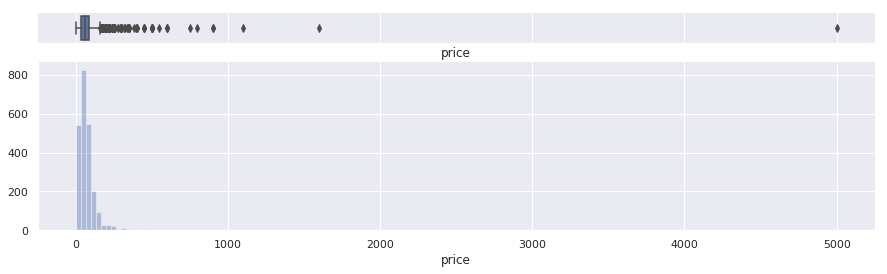

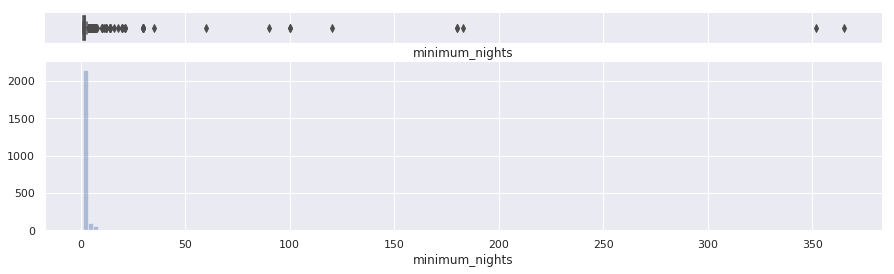

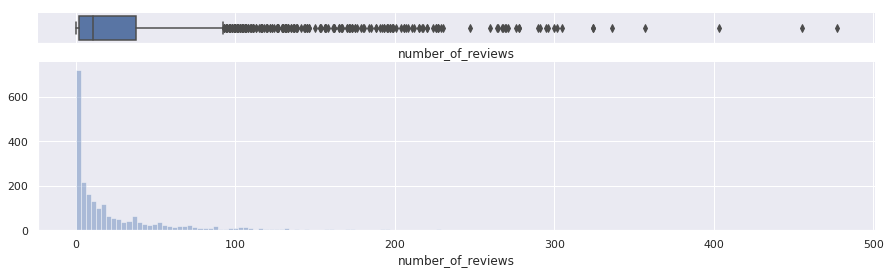

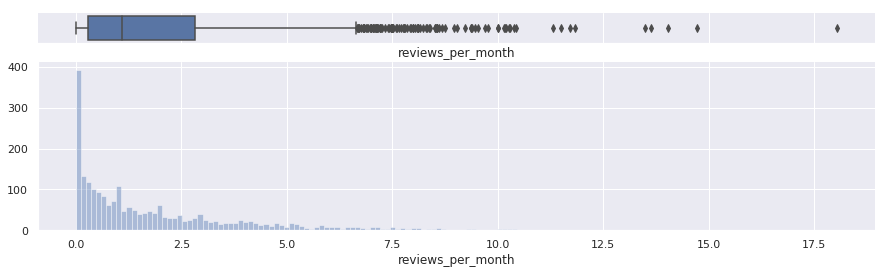

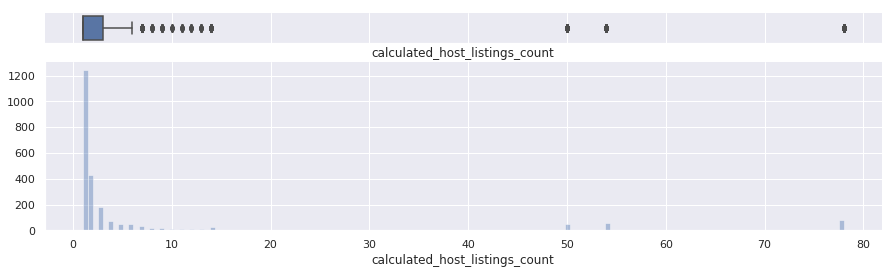

In [21]:
for col in df_short_no_av.columns:
    plotHistBox(col)

In [22]:
# hist = df_short_no_av.hist(bins=50, figsize=(20,10))

### Remove Price Outliers

In [23]:
print(len(df.loc[df.price > 300]))
df = df.loc[df.price < 300]

38


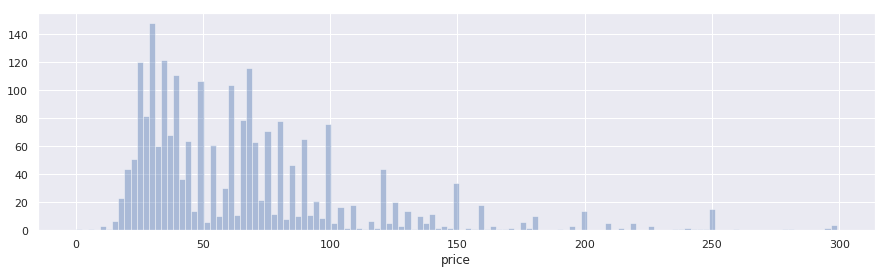

In [24]:
plt.figure(figsize=(15,4))
dp = sns.distplot(df.price, 125, kde=False)

In [25]:
df.isnull().any().any()

False

In [26]:
set(df.property_type)

{'Apartment',
 'Barn',
 'Bed and breakfast',
 'Boat',
 'Boutique hotel',
 'Bungalow',
 'Cabin',
 'Camper/RV',
 'Casa particular (Cuba)',
 'Condominium',
 'Cottage',
 'Farm stay',
 'Guest suite',
 'Guesthouse',
 'Hostel',
 'Hotel',
 'House',
 'Hut',
 'Loft',
 'Other',
 'Serviced apartment',
 "Shepherd's hut (U.K., France)",
 'Tent',
 'Tiny house',
 'Townhouse',
 'Yurt'}

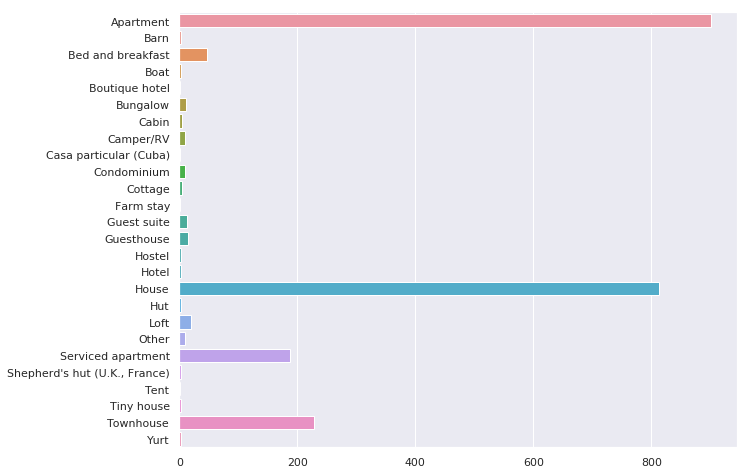

In [27]:
plt.figure(figsize=(10,8))
cnt = Counter(df.property_type.sort_values())
ax = sns.barplot(x=list(cnt.values()), y=list(cnt.keys()))

In [28]:
df.dtypes

neighbourhood                      object
property_type                      object
accommodates                      float64
latitude                          float64
longitude                         float64
bathrooms                         float64
bedrooms                          float64
beds                              float64
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
entire_home_no                      uint8
entire_home_yes                     uint8
dtype: object

In [29]:
df = df.drop_duplicates()

In [30]:
df.shape

(2294, 16)

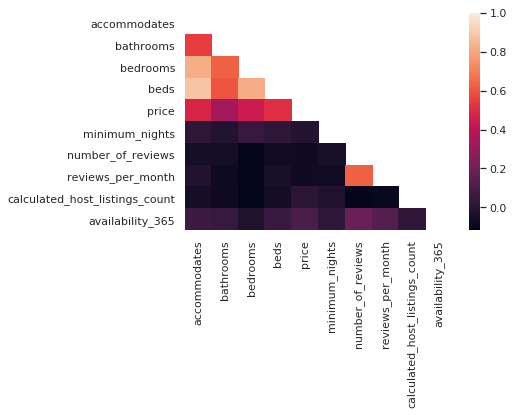

In [31]:
# numeric_df = df.select_dtypes(include=[np.number])
corr = df_short.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask)

In [32]:
df_no_geo.describe()

,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,entire_home_no,entire_home_yes
count,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000,2342.000000
mean,3.116567,1.241674,1.435098,1.811699,76.905209,2.818531,31.573442,1.914389,6.989752,120.853117,0.470965,0.529035
std,2.147207,0.607940,0.983772,1.538341,129.986696,13.202848,51.310593,2.182933,16.874385,128.240186,0.499263,0.499263
min,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,35.000000,1.000000,2.000000,0.290000,1.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,1.000000,59.500000,2.000000,11.000000,1.095000,1.000000,71.000000,0.000000,1.000000
75%,4.000000,1.000000,2.000000,2.000000,85.000000,2.000000,38.000000,2.830000,3.000000,212.000000,1.000000,1.000000
max,16.000000,12.500000,13.000000,24.000000,5000.000000,365.000000,477.000000,18.030000,78.000000,365.000000,1.000000,1.000000


In [33]:
map_json = "map/bristol-polygon.shp"
map_df = gpd.read_file(map_json)

In [34]:
# map_df.plot(figsize=(10,10))

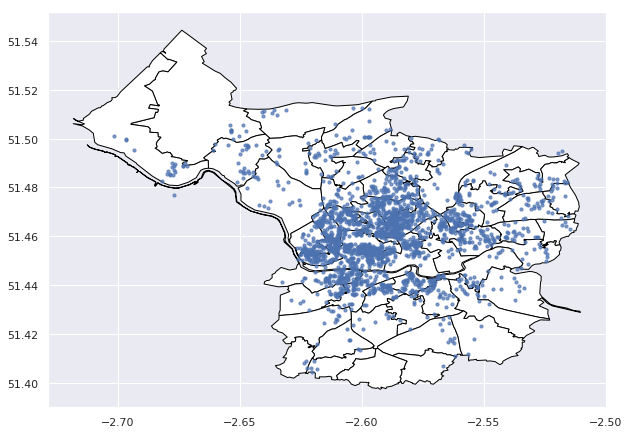

In [35]:
map_df.plot(color='white', edgecolor='black', figsize=(10,10))
scatter_map = plt.scatter(df.longitude, df.latitude, s=10, alpha=0.7)

In [36]:
def plotMap(col, ms, alpha):
    groups = df.groupby(col)
    fig, ax = plt.subplots(figsize=(11.5,11.5))
    ax.set_aspect('equal')

    map_df.plot(ax=ax, color='white', edgecolor='black')
    for name, group in groups:
        plt.scatter(group.longitude, group.latitude, s=ms, alpha=alpha, label=name)
    leg = ax.legend(numpoints=5, bbox_to_anchor=(1.04,1.015))

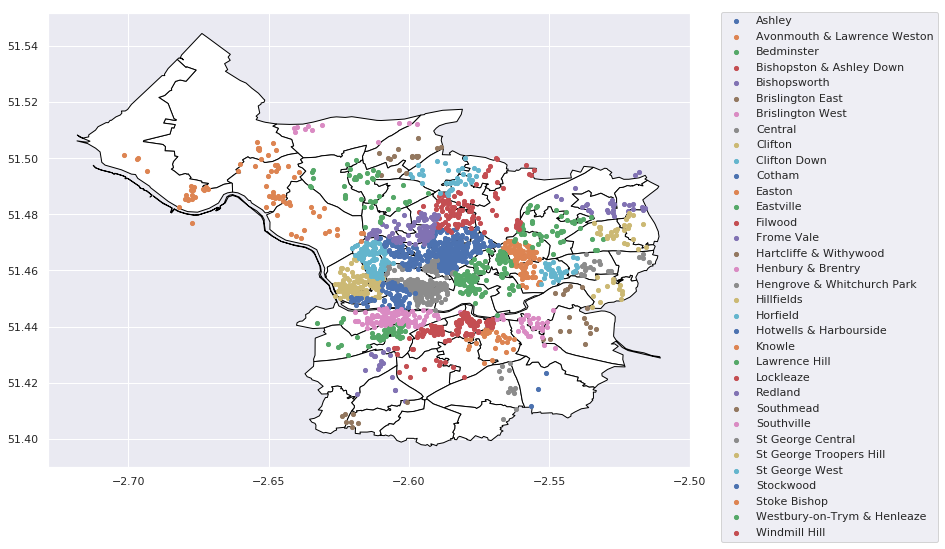

In [37]:
plotMap('neighbourhood', 17, 1)

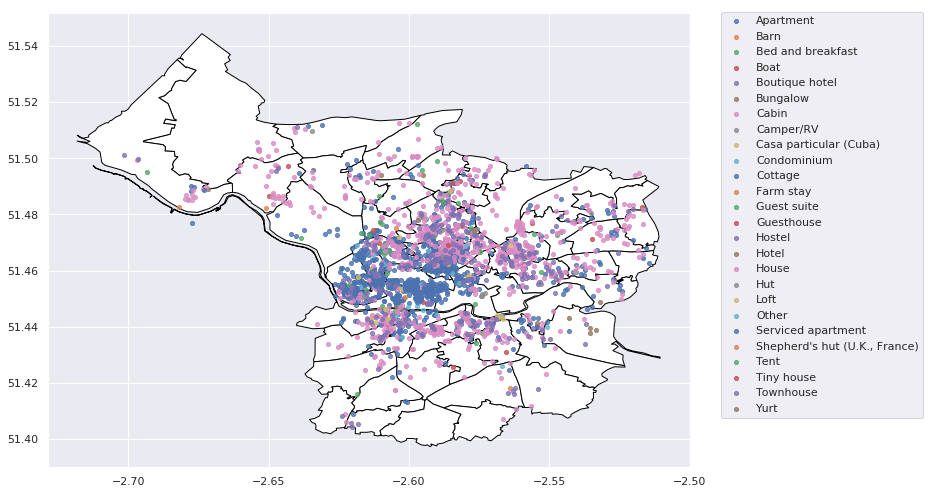

In [38]:
plotMap('property_type', 17, 0.8)

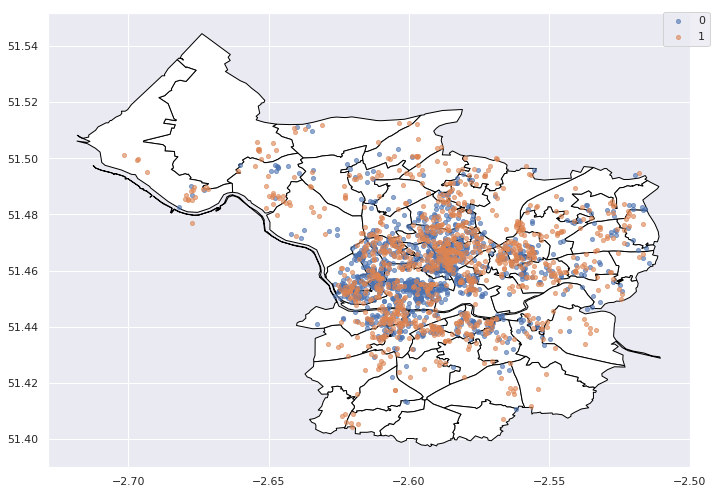

In [39]:
plotMap('entire_home_no', 17, 0.6)

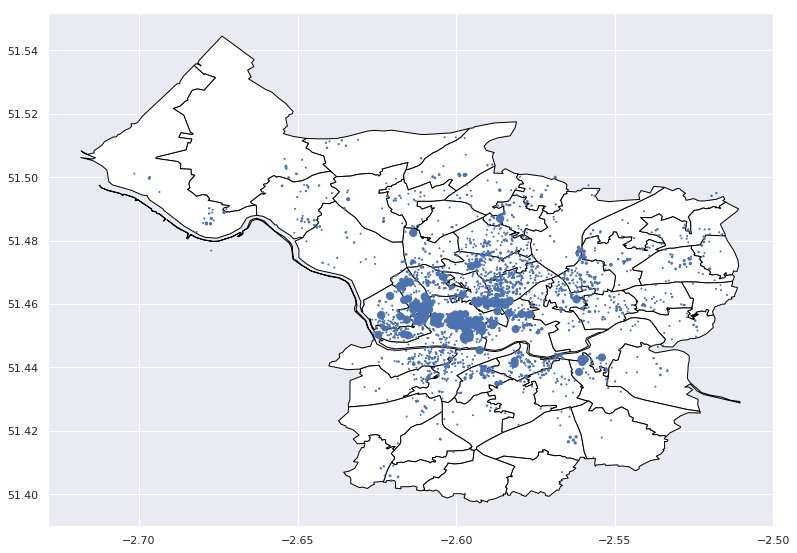

In [40]:
map_df.plot(color='white', edgecolor='black', figsize=(13,13))
sct = plt.scatter(df.longitude, df.latitude, s=df.calculated_host_listings_count, alpha=1)

## Decision Tree

In [41]:
df = df.drop(columns=["longitude", "latitude"])

In [42]:
prop_dummies = pd.get_dummies(df.property_type, prefix="property_type")
df = df.drop(columns="property_type")
df = pd.concat([df, prop_dummies], axis=1)

In [43]:
y = df.neighbourhood
df = df.drop(columns="neighbourhood")

In [44]:
# y_dummies = pd.get_dummies(y, prefix="neighbourhood")

In [47]:
label_encoder = LabelEncoder()
y_le = label_encoder.fit_transform(y)

In [49]:
x = df
# y = y_dummies    # dummies
y = y_le           # label encoded

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

In [51]:
x_cols = x.columns
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1720, 38) (1720,)
(574, 38) (574,)


In [52]:
ova_tree_clf = OneVsRestClassifier(DecisionTreeClassifier())
ova_tree_clf.fit(x_train, y_train)
print(len(ova_tree_clf.estimators_))
print(ova_tree_clf.classes_)
print(ova_tree_clf.multilabel_)
ova_preds = ova_tree_clf.predict(x_test)
# print(ova_tree_clf.predict_proba(x_test))
print(ova_tree_clf.score(x_test, y_test))

34
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
False
0.15331010452961671


In [53]:
cross_val_score(ova_tree_clf, x, y, cv=10)

/home/dtp/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.08230453, 0.1120332 , 0.07983193, 0.10683761, 0.12068966,
       0.09649123, 0.20535714, 0.22624434, 0.21198157, 0.09722222])

In [54]:
# for e in ova_tree_clf.estimators_:
#     print(e.feature_importances_)
#     print()

In [56]:
ovo_tree_clf = OneVsOneClassifier(DecisionTreeClassifier())
ovo_tree_clf.fit(x_train, y_train)
print(len(ovo_tree_clf.estimators_))
ovo_preds = ovo_tree_clf.predict(x_test)
# print(ovo_tree_clf.predict_proba(x_test))
print(ovo_tree_clf.score(x_test, y_test))

561
0.1759581881533101


In [64]:
cross_val_score(ovo_tree_clf, x, y, cv=10)

/home/dtp/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.17283951, 0.17012448, 0.16386555, 0.17948718, 0.14655172,
       0.18421053, 0.23214286, 0.26696833, 0.25806452, 0.15740741])

In [58]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(x_train, y_train)
dec_tree_preds = tree_clf.predict(x_test)

In [59]:
print(tree_clf.tree_)

In [60]:
tree_clf.decision_path(x_test)

<574x2181 sparse matrix of type '<class 'numpy.int64'>'
	with 9251 stored elements in Compressed Sparse Row format>

In [61]:
print(tree_clf.predict_proba(x_test))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [62]:
tree_clf.score(x_test, y_test)

0.18466898954703834

In [63]:
cross_val_score(tree_clf, x, y, cv=10)

/home/dtp/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.1399177 , 0.16182573, 0.1092437 , 0.17521368, 0.14655172,
       0.15789474, 0.20089286, 0.23529412, 0.21658986, 0.10648148])